# Exploring the Data

### Introduction

Now that we have properly coerced our data, it's time for us to start exploring our data.  As we'll see, with our data properly formatted, exploring the data will be easier -- and importantly more accurate. 

### Loading our data

In [11]:
from sqlalchemy import create_engine
# change the jeffreykatz to your postgres username
conn_string = 'postgresql://jeffreykatz@localhost/ecommerce'
conn = create_engine(conn_string)

In [4]:
import pandas as pd
df = pd.read_sql("select * from transactions", conn)
df[:2]

,index,transaction_id,customer_id,product,gender,device_type,country,state,city,category,...,delivery_type,quantity,transaction_start,transaction_result,amount,individual_price,month,week,dow,hour
0,0,40170,1348959766,Hair Band,Female,Web,United States,New York,New York City,Accessories,...,one-day deliver,12,1,0,6910.0,576.0,11.0,46.0,4.0,22.0
1,1,33374,2213674919,Hair Band,Female,Web,United States,California,Los Angles,Accessories,...,one-day deliver,17,1,1,1699.0,100.0,5.0,19.0,6.0,6.0


### Starting an analysis

When performing data analysis the first step is to find at least one metric we are trying to optimize.  For example, profit.

Let's look at the columns above to see if there is a component like that.

In [9]:
df.columns

Index(['index', 'transaction_id', 'customer_id', 'product', 'gender',
       'device_type', 'country', 'state', 'city', 'category',
       'customer_login_type', 'delivery_type', 'quantity', 'transaction_start',
       'transaction_result', 'amount', 'individual_price', 'month', 'week',
       'dow', 'hour'],
      dtype='object')

Looking at the columns, above, there is nothing that says profit -- but perhaps amount is really the revenue.  If we select the columns of `quantity`, `indidivual_price`, and `amount`, we see that the individual_price times the quantity does (almost) equal the amount.

In [10]:
selected_cols = df[['quantity', 'individual_price', 'amount']]
selected_cols[:2]

,quantity,individual_price,amount
0,12,576.0,6910.0
1,17,100.0,1699.0


Ok, so we have identified *amount* as a metric we can try to optimize.  The attribute we are trying to optimize is called the **target**.

Now the other information in our dataset, we can use to determine how to promote more revenue.  For example, maybe we will find that individuals from a certain location purchase more than others, or that certain products are particularly profitable in certain regions.  

These components that influence our target are our **features**.  We can think of our features as inputs that influence our target -- here revenue.

> It may be good to see what is the dimension we are trying to optimize revenue across - for example revenue per month, or revenue per customer.  But oftentimes the problems are not so well defined, so let's hold off on that for now.

### Seeing the influence

Now to see what is valuable in influencing our revenue.  For example, if there let's see which weeks we have the most amount of revenue.

In [21]:
query = """select week, sum(amount) total_amount 
from transactions group by week order by week"""
df = pd.read_sql(query, conn)
df[:2]


,week,total_amount
0,1.0,3624522.0
1,2.0,9666250.0


So we just group by the week and can order by that week to see the data sequentially.

<AxesSubplot: >

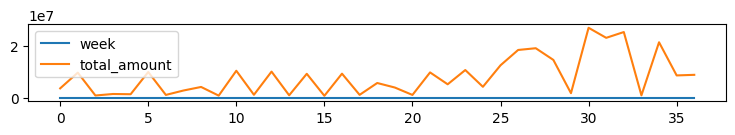

In [23]:
df.plot(figsize=(9, 1))

### Moving this to a function

Now the above group by is something we likely want to explore with all of our attributes.  So let's move this into a function.

In [31]:
def build_grouped_by(table_name, col, engine, order_by_col = False):
    if order_by_col:
        query = f"""select {col}, sum(amount) total_amount from {table_name} group by {col} order by {col} asc"""
    else:
        query = f"""select {col}, sum(amount) total_amount from {table_name} group by {col} order by total_amount desc"""

    grouped = pd.read_sql(query, engine)
    return grouped

> Above we give options for ordering by the column -- like the week above -- or for ordering by the total amount most to least.

Ok, so now we could collect all of our time columns and explore them.

In [32]:
time_cols = ['month', 'week', 'dow', 'hour']

In [35]:
group_by_month = build_grouped_by('transactions', 'month', conn, order_by_col = True)[:4]
group_by_month[:4]

,month,total_amount
0,1.0,11952387.0
1,2.0,12733940.0
2,3.0,8051501.0
3,4.0,11220357.0


In [36]:
group_by_month_desc_amount = build_grouped_by('transactions', 'month', conn, order_by_col = False)[:4]
group_by_month_desc_amount[:4]

,month,total_amount
0,11.0,77712351.0
1,10.0,64841654.0
2,12.0,41912057.0
3,9.0,29880412.0


And we can also write a function to plot our dataframe.

In [37]:
import matplotlib.pyplot as plt
def print_grouped_by(grouped):
    selected_group = grouped[grouped.iloc[:, 0].values != None]
    plt.figure(figsize=(14, 2))
    plt.scatter(selected_group.iloc[:10, 0], selected_group.iloc[:10, 1])
    plt.show()

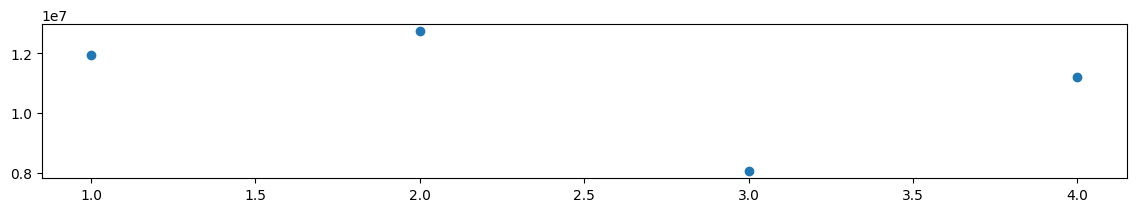

In [39]:
print_grouped_by(group_by_month)

### Exploring multiple columns

In [ ]:
def build_grouped_bys(table_name, cols, engine):
    grouped_bys = []
    for col in cols:
        grouped = build_grouped_by(table_name, col, engine)
        grouped_bys.append(grouped)
    return grouped_bys

Now one limitation of the above data is that we only have data from months September through January 2014.  Normally, we would like to compare year over year sales from the same month or even day.  For example, January 2014 should be compared against January 2013 -- not December.

Another thing to notice is that our numbers for September 2013 and January 2014 are a lot smaller than the other months.  Perhaps we have missing data.  One first check is to see the number of days accounted for in both of these months.

In [98]:
query = """select EXTRACT(month FROM date) as month, count(distinct(EXTRACT(day FROM date))) from transactions group by month"""
overall_year_month = pd.read_sql(query, conn)

In [99]:
overall_year_month

,month,count
0,1.0,13
1,9.0,11
2,10.0,31
3,11.0,29
4,12.0,31


So it looks like our months of October through December are essentially complete while September and January has only 1/3 of the days.  Let's see if the days are at least contiguous.  To do so, let's see the min and maximum days in the dataset.

In [100]:
query = """select min(date), max(date) from transactions"""
pd.read_sql(query, conn)

,min,max
0,2013-09-20,2014-01-13


Ok so it does look like there are not gaps in our dates for these months.  This means grouping by something like weeks (instead of months) may be more appropriate.

> Skipping first and last week.

In [1]:
query = """select count(distinct(extract(day from date))), EXTRACT(week FROM date) as week where week = 38 group by week"""
# overall_year_month = pd.read_sql(query, conn)

In [110]:
query = """select EXTRACT(week FROM date) as week, EXTRACT(year FROM date) as year, SUM(total_amount) 
from transactions group by week, year order by year, week OFFSET 2 limit 16"""
overall_year_month = pd.read_sql(query, conn)
overall_year_month

,week,year,sum
0,39.0,2013.0,595164.0
1,40.0,2013.0,738260.0
2,41.0,2013.0,754522.0
3,42.0,2013.0,982342.0
4,43.0,2013.0,992948.0
5,44.0,2013.0,1089473.0
6,45.0,2013.0,1339593.0
7,46.0,2013.0,1366328.0
8,47.0,2013.0,1248567.0
9,48.0,2013.0,1667409.0


In [ ]:
from transactions

### Resources

[Crosstab](https://stackoverflow.com/questions/3002499/postgresql-crosstab-query/11751905#11751905)